In [134]:
%matplotlib inline

In [135]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from condlib import conductance_matrix_READ
from timeit import default_timer as timer

In [136]:
# Memory array parameters
rL = 12
rHRS = 1e6
rPU = 1e3
n = 16
vRead = [0.5, 1.0, 1.6, 2.0, 2.5, 3.0, 4.0]

In [137]:
hubList = []
lsbList = []
WLvoltagesList = []
BLvoltagesList = []
cellVoltagesList = []
mask = np.ones((n, n), dtype=bool)
mask[n-1][n-1] = False

In [138]:
for v in vRead:
    # Voltages for BLs and WLs (read voltages, unselected floating)
    vBLsel = 0.0
    vWLsel = v

    start_t = timer()
    # Create conductance matrix
    conductancematrix, iinvector = conductance_matrix_READ(n, rL, rHRS, rPU,
                                                           vWLsel, vBLsel,
                                                           isel=n-1, jsel=n-1, verbose=False)
    # Convert to sparse matrix (CSR)
    conductancematrix = csr_matrix(conductancematrix)
    # Solve
    voltages = spsolve(conductancematrix, iinvector)
    stop_t = timer()

    # Separate WL and BL nodes and calculate cell voltages
    WLvoltages = voltages[:n*n].reshape((n, n))
    BLvoltages = voltages[n*n:].reshape((n, n))
    WLvoltagesList.append(WLvoltages)
    BLvoltagesList.append(BLvoltages)

    cellVoltages = abs(BLvoltages - WLvoltages)
    cellVoltagesList.append(cellVoltages)

    # Calculate Highest Unselected Bit and Lowest Selected Bit
    hub = np.max(cellVoltages[mask])
    lsb = cellVoltages[n-1][n-1]
    hubList.append(hub)
    lsbList.append(lsb)
    
    print "{:.4f} sec".format(stop_t - start_t)
    print "Write voltage          : {:.4f} V".format(v)
    print "Highest unselected bit : {:.4f} V".format(hub)
    print "Lowest selected bit    : {:.4f} V".format(lsb)

0.0077 sec
Write voltage          : 0.5000 V
Highest unselected bit : 0.2380 V
Lowest selected bit    : 0.4911 V
0.0052 sec
Write voltage          : 1.0000 V
Highest unselected bit : 0.4760 V
Lowest selected bit    : 0.9822 V
0.0067 sec
Write voltage          : 1.6000 V
Highest unselected bit : 0.7615 V
Lowest selected bit    : 1.5715 V
0.0048 sec
Write voltage          : 2.0000 V
Highest unselected bit : 0.9519 V
Lowest selected bit    : 1.9644 V
0.0054 sec
Write voltage          : 2.5000 V
Highest unselected bit : 1.1899 V
Lowest selected bit    : 2.4555 V
0.0058 sec
Write voltage          : 3.0000 V
Highest unselected bit : 1.4279 V
Lowest selected bit    : 2.9467 V
0.0049 sec
Write voltage          : 4.0000 V
Highest unselected bit : 1.9038 V
Lowest selected bit    : 3.9289 V


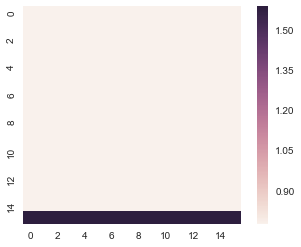

In [139]:
if n < 9:
    sns.heatmap(WLvoltagesList[2], square=True)
else:
    sns.heatmap(WLvoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/read_mapWL_{}.png".format(n), dpi=300)

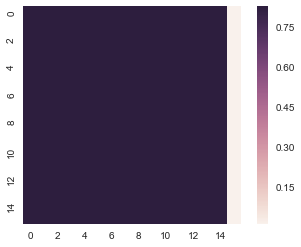

In [140]:
if n < 9:
    sns.heatmap(BLvoltagesList[2], square=True)
else:
    sns.heatmap(BLvoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/read_mapBL_{}.png".format(n), dpi=300, figsize=(10,10))

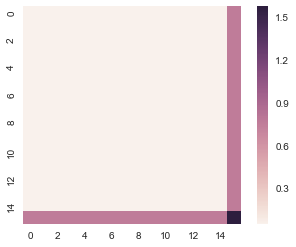

In [141]:
if n < 9:
    sns.heatmap(cellVoltagesList[2], square=True)
else:
    sns.heatmap(cellVoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/read_mapCell_{}.png".format(n), dpi=300, figsize=(10,10))

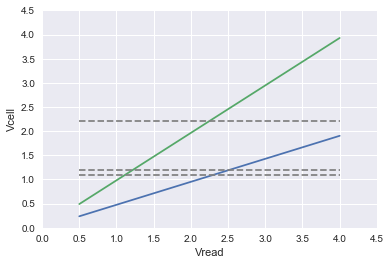

In [142]:
plt.plot(vRead, hubList, vRead, lsbList)
plt.plot([0.5, 4], [1.1, 1.1], [0.5, 4], [2.2, 2.2], c='gray', ls='--')
plt.plot([0.5, 4], [1.2, 1.2], c='gray', ls='--')
plt.xlim([0,4.5])
plt.ylim([0,4.5])
plt.ylabel("Vcell")
plt.xlabel("Vread")
plt.savefig("figures/read_margin_{}.png".format(n), dpi=300, figsize=(10,12))
plt.show()

In [143]:
# Find window
windowlsb = np.interp([1.2, 2.2], lsbList, vRead)
windowhub = np.interp(1.1, hubList, vRead)
print windowlsb
print windowhub

[ 1.22172479  2.23982878]
2.31112066614


In [144]:
# Output data to csv
np.savetxt("data/read_margin_{}.csv".format(n),
           np.vstack((vRead, lsbList, hubList)).T,
           delimiter=',',
           header="Vread,VcellLSB,VcellHUB",
           footer=",WindowLSB = {} - {}, WindowHSB < {}".format(windowlsb[0], windowlsb[1], windowhub),
           comments='')
np.savetxt("data/read_mapCell_{}.csv".format(n),
           cellVoltagesList[2],
           delimiter=',')
np.savetxt("data/read_mapWL_{}.csv".format(n),
           WLvoltagesList[2],
           delimiter=',')
np.savetxt("data/read_mapBL_{}.csv".format(n),
           BLvoltagesList[2],
           delimiter=',')